In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
import torch
import argparse
from models.utils.gan_joiner import GAN
from models.utils.losses import *
from models.utils.metrics import *
from models.utils.misc import *
from models.unet import UNet
from models.utils.datasets import *

from torchvision import datasets, transforms, models
import torchvision.transforms as T

In [2]:
from fastai import torch_core

In [3]:
H = 320
W= 320
bs = 5
nclass = 4
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
#transform = T.Compose([
#T.Resize((H,W)),
#T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406])
#])

In [5]:
path = './data/ImageNetRotation1k/'

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dloader = data.dataloaders(path,bs=bs) 

In [6]:
GanLoss = GanLossWrapper(beta=0, gamma=0.005,sigma=1)

gan = GAN(num_encoder_layers = 4, nhead=4, backbone = True, num_classes = nclass, bypass=False, hidden_dim=256, 
          batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [7]:
gan.generatorSwitcher()
gan.noiseSwitcher()
print("Noise mode:", gan.noise_mode)
print("Generator mode:", gan.generator_mode)

Noise mode: False
Generator mode: False


In [8]:
gan.paramsToUpdate()
gan.assertParams()

In [9]:
def alt_load(self:Learner, file, with_opt=None, device=None, **kwargs):
    if device is None and hasattr(self.dls, 'device'): device = self.dls.device
    if with_opt is None: self.opt=None
    file = join_path_file(file, self.path/self.model_dir, ext='.pth')
    load_model(file, self.model, self.opt, device=device, **kwargs)
    return self
Learner.load = alt_load

In [7]:
def alt_create_opt(self):
    self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
    if not self.wd_bn_bias:
        #print("Param update")
        for p in self._bn_bias_state(True ): p['do_wd'] = False
    if self.train_bn:
        #print("Param update again")
        for p in self._bn_bias_state(False): p['force_train'] = True
            
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

# Cell
def gan_trainable_params(m):
    #print("Gan trainable parameters update")
    "Return all trainable parameters of `m`"
    if m.generator_mode == True:
        m.noise_mode = True
        for param in m.generator.parameters():
            param.requires_grad = True
        for param in m.model.parameters():
            param.requires_grad = False
    else:
        for param in m.generator.parameters():
            param.requires_grad = False
        for name, param in m.model.named_parameters():
            fb = ["mask","penalty_mask","pos"]
            if name not in fb:
                param.requires_grad = True
            else:
                param.requires_grad = False
    return [p for p in m.parameters() if p.requires_grad]

#torch_core.trainable_params = gan_trainable_params
Learner.create_opt = alt_create_opt

In [8]:
def _do_generator_epoch(self):
    
    for param in self.model.generator.parameters():
        param.requires_grad = True
    for param in self.model.model.parameters():
        param.requires_grad = False
     
    self.model.noise_mode = True
    #self.loss_func.generator_mode = True
    
    self.model.generator_mode = True
    
    self.create_opt()
    
    #checkParam = ["generator.down1.maxpool_conv.1.double_conv.0.weight","model.penalty_mask","model.encoder.encoder.layers.0.self_attn.out_proj.bias"]
#     checkParam = ["model.encoder.encoder.layers.0.self_attn.out_proj.weight"]
#     for name, p in self.model.named_parameters(): 
#         if name in checkParam:
#             print(p, p.requires_grad)
    
    self._do_epoch_train()
    self._do_epoch_validate()
    
    #self.model.generator_mode = False
    
def _do_noise_critic_epoch(self):
    
    for param in self.model.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in self.model.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)

    self.loss_func.generator_mode = False

    self.model.noise_mode = True
    
    self.model.generator_mode = False
    self.create_opt()
    
    checkParam = ["model.backbone.backbone.layer1.1.bn2.weight"]
    for name, p in self.model.named_parameters(): 
        if name in checkParam:
            print(p, p.requires_grad)
    
    self._do_epoch_train()
    self._do_epoch_validate()
    
    #self.model.generator_mode = True
    
def _do_critic_epoch(self):
    
    for param in self.model.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in self.model.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)

    self.loss_func.generator_mode = False
    self.model.noise_mode = False
    self.model.generator_mode = False
    
    self.create_opt()
#     checkParam = ["model.encoder.encoder.layers.0.self_attn.out_proj.weight"]
#     for name, p in self.model.named_parameters(): 
#         if name in checkParam:
#             print(p, p.requires_grad)

    self._do_epoch_train()
    self._do_epoch_validate()

def _GAN_do_fit(self):
    if self.model.generator_mode == True:
        for epoch in range(self.n_epoch):
            self.epoch=epoch
            #Generator Training
            self.opt.set_hypers(lr=self.generator_lr)
            self.lr=self.generator_lr
            #print(self.lr)
            self.loss_func.generator_mode = True
            self._with_events(self._do_generator_epoch, 'epoch', CancelEpochException)

            #Critic Training
            self.opt.set_hypers(lr=self.critic_lr)
            self.lr=self.critic_lr
            #print(self.lr)
            self.loss_func.generator_mode = False
            self._with_events(self._do_critic_epoch, 'epoch', CancelEpochException)
            self._with_events(self._do_noise_critic_epoch, 'epoch', CancelEpochException)
    else:
        for epoch in range(self.n_epoch):
            self.epoch=epoch
            #Critic Training
            self.opt.set_hypers(lr=self.critic_lr)
            self.lr=self.critic_lr
            #print(self.lr)
            self.loss_func.generator_mode = False
            self._with_events(self._do_critic_epoch, 'epoch', CancelEpochException)
            self._with_events(self._do_noise_critic_epoch, 'epoch', CancelEpochException)
            
            self.opt.set_hypers(lr=self.generator_lr)
            self.lr=self.generator_lr
            #print(self.lr)
            self.loss_func.generator_mode = True
            self._with_events(self._do_generator_epoch, 'epoch', CancelEpochException)

def GANfit(self, n_epoch, critic_lr=1e-6, generator_lr = 1e-3, wd=None, cbs=None, reset_opt=False):
    with self.added_cbs(cbs):
        if reset_opt or not self.opt: self.create_opt()
        if wd is None: wd = self.wd
        if wd is not None: self.opt.set_hypers(wd=wd)
        self.critic_lr = critic_lr
        self.generator_lr = generator_lr
        #self.opt.set_hypers(lr=self.lr if lr is None else lr)
        self.n_epoch = n_epoch
        self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
        
Learner._do_fit = _GAN_do_fit
Learner._do_generator_epoch = _do_generator_epoch
Learner._do_critic_epoch = _do_critic_epoch
Learner._do_noise_critic_epoch = _do_noise_critic_epoch
Learner.fit = GANfit

In [10]:
learner = Learner(dloader, gan, loss_func=GanLoss, splitter=trainable_params, 
                  metrics=[Accuracy])

SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=9.12010818865383e-07)

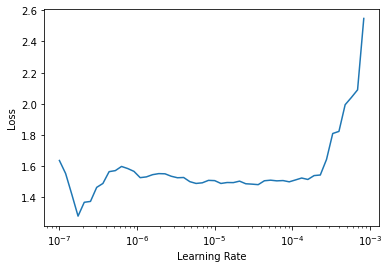

In [11]:
#Critic Loss: TensorCategory(39.4336, device='cuda:0', grad_fn=<AliasBackward>)
learner.lr_find()

Noise mode: True
Generator mode: True


Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='

Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='cuda:0', grad_fn=<AliasBackward>)
Generator Loss
Reconstruction Loss: TensorImage(0., device='

SuggestedLRs(lr_min=5.011872303839482e-08, lr_steep=5.011872303839482e-07)

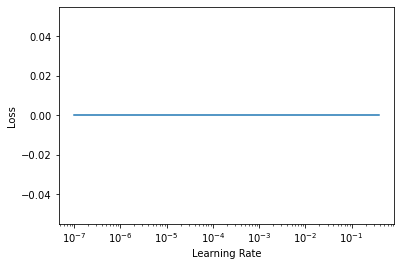

In [12]:
learner.model.generatorSwitcher()
learner.model.noiseSwitcher()
learner.model.paramsToUpdate()
print("Noise mode:", learner.model.noise_mode)
print("Generator mode:", learner.model.generator_mode)
learner.model.assertParams()
learner.lr_find(start_lr=1e-7, end_lr=1)

In [16]:
learner.fit(2, critic_lr=1-7, generator_lr = 1e-7)

epoch,train_loss,valid_loss,Adversarial_loss,Reconstruction_Loss,Accuracy,time
0,0.194794,0.272864,-2.530135,0.285514,0.240000,00:43
0,677136596274266807205888.000000,3628933133827126176251904.000000,-3628933133827126176251904.000000,0.000000,0.240000,00:22
0,nan,nan,nan,0.327174,0.310000,00:31
1,nan,nan,nan,nan,0.310000,00:42
1,nan,nan,nan,0.000000,0.310000,00:22


Parameter containing:
tensor([ -14.4485,   47.9607,  149.1628,  -48.5427,    7.0355,   10.7307,
         -19.0139,    1.1982,   11.8594,   81.6843,   -2.8117,    0.3938,
           4.9066,  102.1968, -127.5427, -103.3052, -137.2662, -116.7131,
          23.0194,  -18.5555,  -25.5104,    0.6239,   60.4850,  -17.7095,
          -1.4675,   35.9805,   -6.5466,  -84.2875,  330.8603,   21.8212,
        -320.7956,    2.7322,   16.7312,  185.3829,    0.6307,   80.7426,
         -66.5774,  -10.2700,  -79.2629,   33.2380,  -61.3685,    1.5536,
        -155.1859,  -24.5799,    4.3337,  -11.4993,   17.6527,   -3.7159,
        -108.8370,  -33.8976,  -69.3589,   24.2964,   45.2684,   11.8844,
          23.4500,   -3.9870,  113.9699,  116.5188,  -18.9923,   -0.7707,
         -80.2739,    6.6324,  -17.3737,  -46.2980], device='cuda:0',
       requires_grad=True) True
Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

KeyboardInterrupt: 

In [47]:
for name, param in learner.model.generator.named_parameters():
    #param.requires_grad = False
    print(name, param.requires_grad)

inc.double_conv.0.weight False
inc.double_conv.0.bias False
inc.double_conv.1.weight False
inc.double_conv.1.bias False
inc.double_conv.3.weight False
inc.double_conv.3.bias False
inc.double_conv.4.weight False
inc.double_conv.4.bias False
down1.maxpool_conv.1.double_conv.0.weight False
down1.maxpool_conv.1.double_conv.0.bias False
down1.maxpool_conv.1.double_conv.1.weight False
down1.maxpool_conv.1.double_conv.1.bias False
down1.maxpool_conv.1.double_conv.3.weight False
down1.maxpool_conv.1.double_conv.3.bias False
down1.maxpool_conv.1.double_conv.4.weight False
down1.maxpool_conv.1.double_conv.4.bias False
down2.maxpool_conv.1.double_conv.0.weight False
down2.maxpool_conv.1.double_conv.0.bias False
down2.maxpool_conv.1.double_conv.1.weight False
down2.maxpool_conv.1.double_conv.1.bias False
down2.maxpool_conv.1.double_conv.3.weight False
down2.maxpool_conv.1.double_conv.3.bias False
down2.maxpool_conv.1.double_conv.4.weight False
down2.maxpool_conv.1.double_conv.4.bias False
down3.ma

In [12]:
for name, param in learner.model.named_parameters():
    fb = ["mask","penalty_mask","pos"]
    #if name not in fb:
    #    param.requires_grad = True
    #else:
    #    param.requires_grad = False
    print(name, param.requires_grad)

generator.inc.double_conv.0.weight True
generator.inc.double_conv.0.bias True
generator.inc.double_conv.1.weight True
generator.inc.double_conv.1.bias True
generator.inc.double_conv.3.weight True
generator.inc.double_conv.3.bias True
generator.inc.double_conv.4.weight True
generator.inc.double_conv.4.bias True
generator.down1.maxpool_conv.1.double_conv.0.weight True
generator.down1.maxpool_conv.1.double_conv.0.bias True
generator.down1.maxpool_conv.1.double_conv.1.weight True
generator.down1.maxpool_conv.1.double_conv.1.bias True
generator.down1.maxpool_conv.1.double_conv.3.weight True
generator.down1.maxpool_conv.1.double_conv.3.bias True
generator.down1.maxpool_conv.1.double_conv.4.weight True
generator.down1.maxpool_conv.1.double_conv.4.bias True
generator.down2.maxpool_conv.1.double_conv.0.weight True
generator.down2.maxpool_conv.1.double_conv.0.bias True
generator.down2.maxpool_conv.1.double_conv.1.weight True
generator.down2.maxpool_conv.1.double_conv.1.bias True
generator.down2.

In [9]:
gan.generator_mode = False
def trainable_params(m):
    "Return all trainable parameters of `m`"
    if m.generator_mode == True:
        m.noise_mode = True
        for param in m.generator.parameters():
            param.requires_grad = True
        for param in m.model.parameters():
            param.requires_grad = False
    else:
        for param in m.generator.parameters():
            param.requires_grad = False
        for name, param in m.model.named_parameters():
            fb = ["mask","penalty_mask","pos"]
            if name not in fb:
                param.requires_grad = True
            else:
                param.requires_grad = False
    return [p for p in m.parameters() if p.requires_grad]

['model.backbone.weight',
 'model.backbone.bias',
 'model.encoder.encoder.layers.0.self_attn.in_proj_weight',
 'model.encoder.encoder.layers.0.self_attn.in_proj_bias',
 'model.encoder.encoder.layers.0.self_attn.out_proj.weight',
 'model.encoder.encoder.layers.0.self_attn.out_proj.bias',
 'model.encoder.encoder.layers.0.linear1.weight',
 'model.encoder.encoder.layers.0.linear1.bias',
 'model.encoder.encoder.layers.0.linear2.weight',
 'model.encoder.encoder.layers.0.linear2.bias',
 'model.encoder.encoder.layers.0.norm1.weight',
 'model.encoder.encoder.layers.0.norm1.bias',
 'model.encoder.encoder.layers.0.norm2.weight',
 'model.encoder.encoder.layers.0.norm2.bias',
 'model.encoder.encoder.layers.1.self_attn.in_proj_weight',
 'model.encoder.encoder.layers.1.self_attn.in_proj_bias',
 'model.encoder.encoder.layers.1.self_attn.out_proj.weight',
 'model.encoder.encoder.layers.1.self_attn.out_proj.bias',
 'model.encoder.encoder.layers.1.linear1.weight',
 'model.encoder.encoder.layers.1.linear1